In [328]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [329]:

def padding (img, dimx, dimy):
    dimx_zeros = dimx - img.shape[1]
    dimy_zeros = dimy - img.shape[0]
    dimx_left = int(dimx_zeros/2)
    dimx_right = dimx_zeros-dimx_left
    dimy_top = int(dimy_zeros/2)
    dimy_down = dimy_zeros-dimy_top

    img_out = np.zeros((dimy, dimx, img.shape[2]))
    img_out[dimy_top:dimy-dimy_down, dimx_left: dimx-dimx_right] = img
 #   for iter in range(img.shape[0]):
#        for iter2 in range(img.shape[1]):
#            img_out[dimy_top+iter, dimx_left+iter2, :] = img[iter, iter2, :]
  #   	     print(img[iter, iter2, :])
 #	     print(img_out[iter+dimy_top, iter2+dimx_left, :])
    return img_out


In [330]:
def corr2d (img, ker):
    #print(img.shape)
    return np.multiply(img, ker).sum()

def nonlinear_func(img):
    return img

In [331]:
def conv2d (input_img, ker, nonlinear_func, stride=(1,1), pad='same'):
    img_out = []
    if pad =='same':
        dimy = stride[0]*(input_img.shape[0]-1)+ker.shape[0]
        dimx = stride[1]*(input_img.shape[1]-1)+ker.shape[1]
        img_padded = padding(input_img, dimx, dimy)
        img_out = np.zeros((input_img.shape[0], input_img.shape[1]))
    else:
        if((input_img.shape[0]-ker.shape[0])%stride[0]==0):
            dimy = input_img.shape[0]
        else:
            dimy = input_img.shape[0]+stride[0]-(input_img.shape[0]-ker.shape[0])%stride[0]
        if((input_img.shape[1]-ker.shape[1])%stride[1]==0):
            dimx = input_img.shape[1]
        else:
            dimx = input_img.shape[1]+stride[1]-(input_img.shape[1]-ker.shape[1])%stride[1]
        
        img_padded = padding(input_img, dimx, dimy)
        img_out = np.zeros((int((dimy-ker.shape[0])/stride[0])+1, (int((dimx-ker.shape[1])/stride[1])+1)))

    ker_rev = np.zeros([ker.shape[1], ker.shape[0], ker.shape[2]])
#     print(ker_rev.shape)
#     print(ker.shape)
    for iter in range(ker.shape[0]):
        for iter2 in range(ker.shape[1]):
            ker_rev[ker.shape[1]-1-iter2, ker.shape[0]-1-iter] = ker[iter, iter2]

    ker_rev_y = ker_rev.shape[0]
    ker_rev_x = ker_rev.shape[1]
#     print(ker_rev_y)
#     print(ker_rev_x)
#     print(img_padded.shape)
    for iter in range(int((dimy-ker_rev.shape[0])/stride[0]) +1):
        for iter2 in range(int((dimx-ker_rev.shape[1])/stride[1])+1 ):
	    #print(iter)
	    #print(iter2)
            img_out[iter, iter2] =corr2d(img_padded[iter*stride[0]:iter*stride[0]+ker_rev_y, iter2*stride[1]:iter2*stride[1]+ker_rev_x], ker_rev)
#     print(img_out.shape)
    return nonlinear_func(img_out)

In [332]:
def pool_func(img):
    return img.min()

def pooling(input_img, pool_func, pool_window=(1,1), stride = (1,1)):
    if((input_img.shape[1]-pool_window[1])%stride[1]==0):
        dimx = input_img.shape[1]
    else:
        dimx = input_img.shape[1]+stride[1]-(input_img.shape[1]-pool_window[1])%stride[1]
    
    if((input_img.shape[0]-pool_window[0])%stride[0]==0):
        dimy = input_img.shape[0]
    else:
        dimy = input_img.shape[0]+stride[0]-(input_img.shape[0]-pool_window[0])%stride[0]
    input_pad = np.zeros((input_img.shape[0], input_img.shape[1], 1))
    input_pad[:, :, 0] = input_img
    input_img = padding(input_pad, dimx, dimy)
    img_out = np.zeros((int((dimy-pool_window[0])/stride[0])+1, (int((dimx-pool_window[1])/stride[1])+1)))

    pool_window_x = pool_window[1]
    pool_window_y = pool_window[0]

    for iter in range(int((dimy-pool_window_y)/stride[0]) +1):
        for iter2 in range(int((dimx-pool_window_x)/stride[1])+1 ):
	    #print(iter)
	    #print(iter2)
            img_out[iter, iter2] =pool_func(input_img[iter*stride[0]:iter*stride[0]+pool_window_y, iter2*stride[1]:iter2*stride[1]+pool_window_x])
#     print(img_out.shape)
    return img_out

In [333]:
def conv_layer(input_img, num_kernels, nonlinear_func, kernels, stride = (1, 1), pad = 'same'):
    if pad =='same':
        dimy = stride[0]*(input_img.shape[0]-1)+kernels[0].shape[0]
        dimx = stride[1]*(input_img.shape[1]-1)+kernels[0].shape[1]
        img_padded = padding(input_img, dimx, dimy)
        img_out = np.zeros((input_img.shape[0], input_img.shape[1], num_kernels))
#         print(img_out.shape)
    else:
        if((input_img.shape[0]-kernels[0].shape[0])%stride[0]==0):
            dimy = input_img.shape[0]
        else:
            dimy = input_img.shape[0]+stride[0]-(input_img.shape[0]-kernels[0].shape[0])%stride[0]
        if((input_img.shape[1]-kernels[0].shape[1])%stride[1]==0):
            dimx = input_img.shape[1]
        else:
            dimx = input_img.shape[1]+stride[1]-(input_img.shape[1]-kernels[0].shape[1])%stride[1]
        img_padded = padding(input_img, dimx, dimy)
        img_out = np.zeros((int((dimy-kernels[0].shape[0])/stride[0])+1, (int((dimx-kernels[0].shape[1])/stride[1])+1), num_kernels))
    
    for iter in range(num_kernels):
#         print(kernels.shape)
        img_out[:, :, iter] = conv2d(input_img, kernels[iter], nonlinear_func, stride, pad)
#     print(input_img.shape)
#     print(img_out.shape)
#     print(pad)
    return img_out

In [334]:
def pool_layer(input_img, pool_func, pool_window=(1,1), stride = (1,1)):
    if((input_img.shape[1]-pool_window[1])%stride[1]==0):
        dimx = input_img.shape[1]
    else:
        dimx = input_img.shape[1]+stride[1]-(input_img.shape[1]-pool_window[1])%stride[1]
    
    if((input_img.shape[0]-pool_window[0])%stride[0]==0):
        dimy = input_img.shape[0]
    else:
        dimy = input_img.shape[0]+stride[0]-(input_img.shape[0]-pool_window[0])%stride[0]
    
    input_img = padding(input_img, dimx, dimy)
    
    img_out = np.zeros((int((dimy-pool_window[0])/stride[0])+1, (int((dimx-pool_window[1])/stride[1])+1), input_img.shape[2]))
    for iter in range(input_img.shape[2]):
#         print(input_img.shape)
        img_out[:, :, iter] = pooling(input_img[:, :, iter], pool_func, pool_window, stride)
    return img_out

In [335]:
def conv_net(input_img, num_layers, ker_nums, kernels, strides, paddings, nonlinear_funcs, pool_funcs, pool_windows, pool_strides):
    img_out = input_img
    current_ker_count = 0
    for iter in range(num_layers):
        img_out = conv_layer(img_out, ker_nums[iter], nonlinear_funcs[iter], kernels[current_ker_count:current_ker_count+ker_nums[iter]], strides[iter], paddings[iter] )
        current_ker_count = current_ker_count + ker_nums[iter]
        print(img_out.shape)
        img_out = pool_layer(img_out, pool_funcs[iter], pool_windows[iter], pool_strides[iter])
        print(img_out.shape)
    return img_out


In [336]:
# ####Testing the conv_layer
# img = cv2.imread('image.png')
# ker1 = np.zeros((10, 10, 3))
# ker12 = np.ones((10, 10, 3))/30000
# ker1[5, 5, :] = 1
# # print(ker1)
# ker2 = []
# ker2.append(ker1)
# ker2.append(ker12)
# img_out1 = conv_layer(img, 2, nonlinear_func, np.array(ker2),  stride = (5, 5), pad = 'valid')
# print(img_out1.shape)
# img_out1 = pool_layer(img_out1, pool_func, pool_window=(2,2), stride = (2,2))
# # img_out1 = pooling(img_out1, pool_func, pool_window=(2,2), stride = (2,2))
# # img_out1 = conv2d(img, ker1*1000, nonlinear_func, stride = (5, 5), pad = 'valid')
# # plt.imshow(img_out1, cmap = 'gray')
# #img_out1 = padding(img, img.shape[1]+10, img.shape[0]+1000)
# # print(img_out1.shape[2])

# fig = plt.figure(figsize=(img_out1.shape[0], img_out1.shape[1]))  # width, height in inches

# for i in range(img_out1.shape[2]):
#     sub = fig.add_subplot(img_out1.shape[2], 1, i + 1)
#     sub.imshow(img_out1[:,:, i], cmap = 'gray', norm=None)

# plt.show()

In [341]:
img = cv2.imread('image.png')
num_layers = 2

ker_nums_layer1 = 2
ker_nums_layer2 = 3
ker_nums = []

ker_nums.append(ker_nums_layer1)
ker_nums.append(ker_nums_layer2)

kernels = []

kl1n1 = np.ones((4, 4, 3))
kl1n2 = np.zeros((4, 4, 3))
kl1n2[2, 2, :] = 1

kernels.append(kl1n1)
kernels.append(kl1n2)

kl2n1 = np.random.randint(2, size = (6, 6, 2))
kl2n2 = np.ones((6, 6, 2))
kl2n3 = np.random.randint(10, size = (6, 6, 2))

kernels.append(kl2n1)
kernels.append(kl2n2)
kernels.append(kl2n3)

kernels = np.array(kernels)

# print(kernels[3].shape)

stridel1 = (2, 2)
stridel2 = (3, 3)

strides = []
strides.append(stridel1)
strides.append(stridel2)

# print(strides)

paddingl1 = 'valid'
paddingl2 = 'valid'

paddings = []
paddings.append(paddingl1)
paddings.append(paddingl2)

# print(paddings)

nonlinear_funcl1 = nonlinear_func
nonlinear_funcl2 = nonlinear_func

nonlinear_funcs = []
nonlinear_funcs.append(nonlinear_funcl1)
nonlinear_funcs.append(nonlinear_funcl2)

# print(nonlinear_funcs)

pool_funcl1 = pool_func
pool_funcl2 = pool_func

pool_funcs = []
pool_funcs.append(pool_funcl1) 
pool_funcs.append(pool_funcl2) 

# print(pool_funcs)

pool_windowl1 = (3, 3)
pool_windowl2 = (2, 2)

pool_windows = []
pool_windows.append(pool_windowl1)
pool_windows.append(pool_windowl2)

# print(pool_windows)

pool_stridel1 = (2, 2)
pool_stridel2 = (2, 2)

pool_strides = []
pool_strides.append(pool_stridel1)
pool_strides.append(pool_stridel2)

# print(pool_strides)

img_out3 = conv_net(img, num_layers, ker_nums, kernels, strides, paddings, nonlinear_funcs, pool_funcs, pool_windows, pool_strides)


(331, 499, 2)
(165, 249, 2)
(54, 82, 3)
(27, 41, 3)


(27, 41)


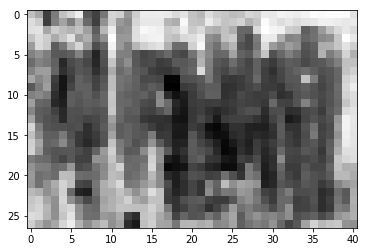

In [342]:
print(img_out3[:, :, 1].shape)
plt.imshow(img_out3[:, :, 2], cmap='gray')